In [219]:
import os
import pickle
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
from librosa import power_to_db
from librosa.core import load
from librosa.display import specshow
from librosa.feature import melspectrogram
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from preprocessing import extract_log_mel_feats

In [2]:
train_folder = './data/train'

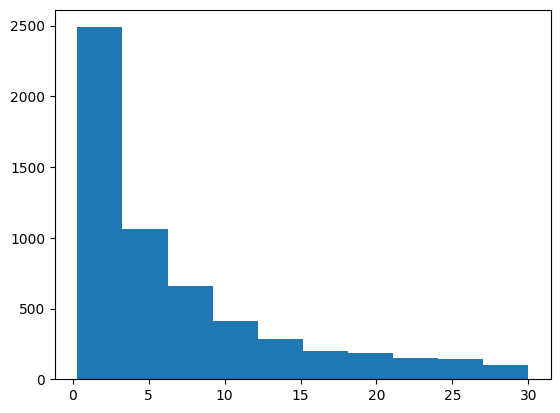

In [3]:
wav_durations = list()
for wav_path in Path(train_folder).glob("*.wav"):
    wav_durations.append(librosa.get_duration(filename=wav_path))

plt.hist(wav_durations)
plt.show()

In [4]:
# СТАРЫЕ ЗНАЧЕНИЯ
# sample_rate = 11025
# fft_size = 1024
# overlap = 4
# hop = fft_size // overlap
# mels = 64

# UPD №1: Больше не ресэмплим записи (16000 Гц -> 11025 Гц), а оставляем исходные 16000 Гц
sample_rate = 16000

# UPD №2: Среди меток встречаются множество различных событий, поэтому нельзя просто взять высокое разрешение во временной или частотной области.
# Нужен компромис => просто пропорционально увеличиваем (на глаз и исходя из опыта) гиперпараметры для расчёта спектра
fft_size = 2048
hop = fft_size // 4

mels = 64

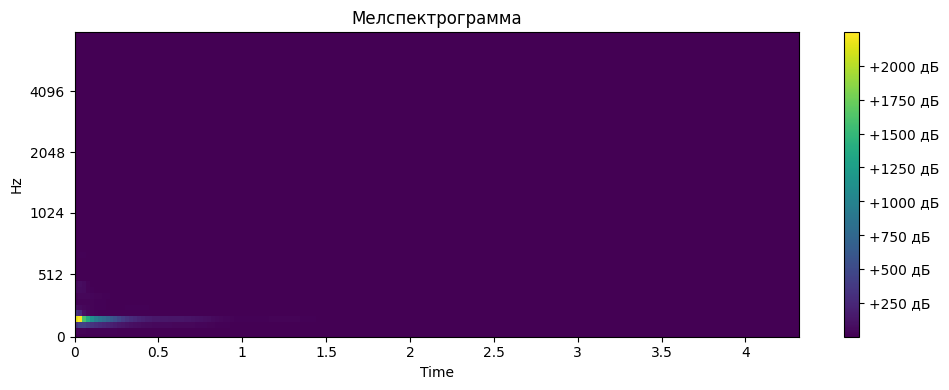

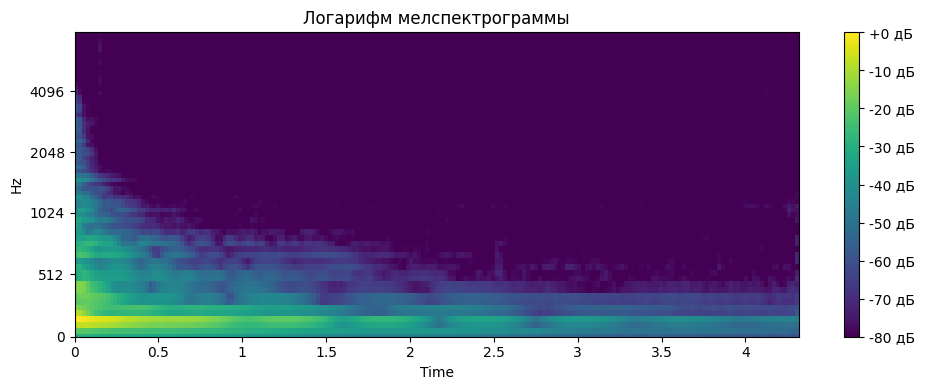

In [5]:
wav_data, sr = load(os.path.join(train_folder, 'edd5f2d5bdab597ab6f1.wav'), sr=sample_rate)
mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, fmax=sample_rate // 2)

plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(mel_spec, y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
specshow(power_to_db(mel_spec, ref=np.max), y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы')
plt.tight_layout()
plt.show()

In [35]:
path_to_csv = os.path.join('./data', 'train.csv')
pickle_train_path = os.path.join('train.pickle')
label_to_id = extract_log_mel_feats('train', path_to_csv, train_folder, pickle_train_path, sample_rate, fft_size, hop, mels)
id_to_label = [label for label, i in label_to_id.items()]

Total files: 5683


5683it [05:48, 16.29it/s]


In [236]:
class DummyNetwork(nn.Module):
    def __init__(self):
        super(DummyNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=96)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.flat = nn.Flatten()
        
        # 33856 - должно соответствовать форме self.flat
        self.fc1 = nn.Linear(60352, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        return x

In [237]:
with open(pickle_train_path, 'rb') as file:
    pickle_train_data = pickle.load(file)
fnames, features, label_ids = zip(*[(item["fname"], item["feature"], item["label_id"]) for item in pickle_train_data])

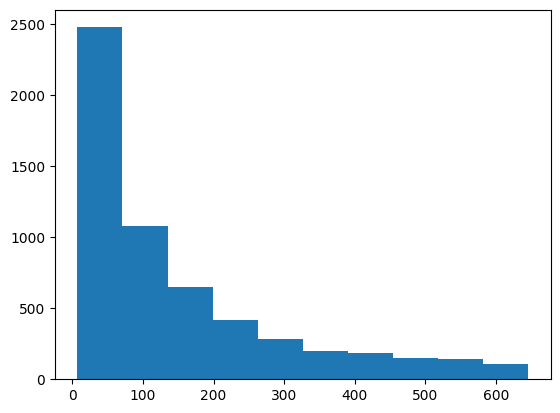

In [238]:
spec_durations = [feature.shape[1] for feature in features]
plt.hist(spec_durations)
plt.show()

In [239]:
class EventDetectionDataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.__prepare_shape(self.x[idx])
        y = self.y[idx]
        return x, y
    
    def __prepare_shape(self, feature):
        feature = feature.copy()
        
        # СТАРОЕ ЗНАЧЕНИЕ
        # N = 64
        # UPD №3: Оценивая разброс по продолжительности записей, выбираем оптимальную продолжительность для одного экземпляра
        N = 100
        
        while feature.shape[-1] < N:
            feature = np.hstack((feature, feature))
        
        # UPD №4: Берём случайный кусок аудиозаписи
        start = np.random.randint(0, feature.shape[-1] - N + 1)
        feature = feature[np.newaxis, :, start: start + N]
        return feature

In [240]:
# Гиперпараметры
test_size=0.3
batch_size=128
n_epoch = 100
learning_rate = 0.0005

device = "cuda:0"

In [241]:
X_train, X_test, y_train, y_test = train_test_split(features, label_ids, test_size=test_size, random_state=0, shuffle=True)

train_dset = EventDetectionDataset(X_train, y_train)
class_weights = torch.from_numpy(compute_class_weight("balanced", classes=list(set(y_train)), y=y_train))

val_dset = EventDetectionDataset(X_test, y_test)

39


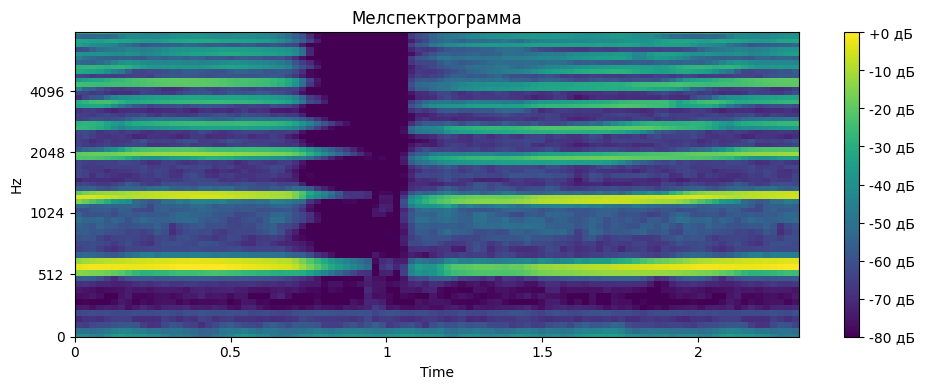

In [242]:
# Проверяем работу Dataset-а (в том числе и случайного среза)
sample_x, sample_y = val_dset[100]
print(sample_y)

plt.figure(figsize=(10, 4))
specshow(sample_x[0], y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap='viridis')
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

In [243]:
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)

# UPD №4: Используем веса классов для балансированния датасета
criterion = nn.CrossEntropyLoss(weight=class_weights.to(torch.float32)).to(device)
network = DummyNetwork().to(device)
# UPD №5: Заменяем SGD на AdamW
optimizer = optim.AdamW(network.parameters(), lr=learning_rate)

train_loss = []
val_loss = []
train_acc = []
val_acc = []
train_f1 = []
val_f1 = []

for e in range(n_epoch):
    print('epoch #', e)

    loss_list = []
    outputs = []
    targets = []

    network = network.train()
    for i_batch, sample_batched in enumerate(train_loader):
        x = sample_batched[0].to(device)
        y = sample_batched[1].to(device)

        output = network(x)
        
        outputs.append(output.detach().cpu().numpy().argmax(axis=1))
        targets.append(y.detach().cpu())
        
        loss = criterion(output, y)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        network.zero_grad(set_to_none=True)
    
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    train_f1.append(f1)
    
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    print('train f1:', f1)
    
    
    loss_list = []
    outputs = []
    targets = []
    network = network.eval()
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x = sample_batched[0].to(device)
            y = sample_batched[1].to(device)
            
            output = network(x)
            outputs.append(output.detach().cpu().numpy().argmax(axis=1))
            targets.append(y.detach().cpu())
            loss_list.append(criterion(output, y).detach().cpu())
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        val_f1.append(f1)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)
        print('val f1:', f1)

epoch # 0
mean train loss: 16.454251443186113
train accuracy: 0.08215725806451613
train f1: 0.083029313045564
mean val loss: 8.293313
val accuracy: 0.0967741935483871
val f1: 0.09018053759863952
epoch # 1
mean train loss: 4.760471613176407
train accuracy: 0.16028225806451613
train f1: 0.1624475664520768
mean val loss: 3.9265506
val accuracy: 0.18533724340175953
val f1: 0.16629029874291001
epoch # 2
mean train loss: 3.5798048357809744
train accuracy: 0.2240423387096774
train f1: 0.22301476257670222
mean val loss: 3.6916485
val accuracy: 0.20117302052785924
val f1: 0.1851657072200137
epoch # 3
mean train loss: 3.669252810939666
train accuracy: 0.24420362903225806
train f1: 0.24451031714642782
mean val loss: 3.6270096
val accuracy: 0.2287390029325513
val f1: 0.18899123363706852
epoch # 4
mean train loss: 3.3851213301381757
train accuracy: 0.2615927419354839
train f1: 0.2627438974483259
mean val loss: 3.718279
val accuracy: 0.23870967741935484
val f1: 0.2234560872525239
epoch # 5
mean trai

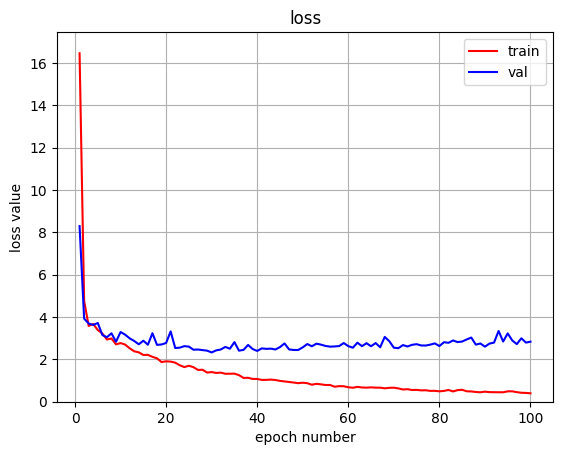

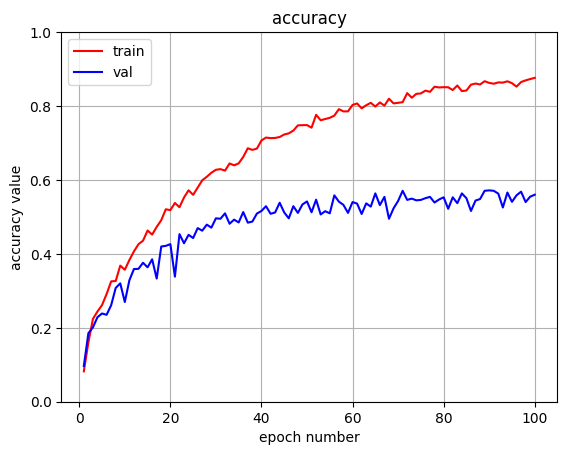

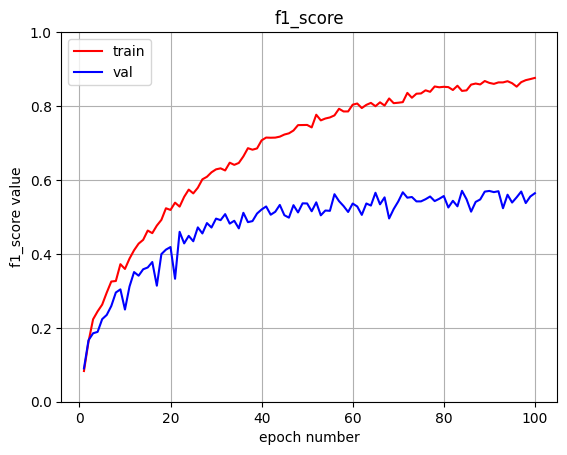

In [244]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_f1, 'r', label='train')
plt.plot(epochs, val_f1, 'b', label='val')
plt.title('f1_score')
plt.xlabel('epoch number')
plt.ylabel('f1_score value')
plt.legend()
plt.grid()
plt.show()